## Analyze A/B Test Results

### Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)

### Introduction <a id='intro'></a>
A/B tests are very commonly performed by data analysts and data scientists. For this project, I will be working to understand the results of an A/B test run by an e-commerce website. The company has developed a new web page in order to try and increase the number of users who "convert" meaning the number of users who decide to pay for the company's product. The goal is to work through the notebook to help the company understand if they should implement this new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
### Part I - Probability

To get started, let's import our libraries.

In [1]:
# import all packages and set plots to be embedded inline
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
df[~df.user_id.duplicated()].converted.mean()

0.1195695564793657

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
dont_line_up = df.query('(group == "treatment" and landing_page == "old_page")' + 
                        'or (group == "control" and landing_page == "new_page")')
len(dont_line_up)

3893

f. Do any of the rows have missing values?

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

**No missing values.**

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
# drop the one's that don't line up found in (1e)
df2 = df.copy()
df2 = df2[~df2.index.isin(dont_line_up.index)]
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [9]:
# double check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2[df2.user_id.duplicated()].user_id

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [12]:
df2[df2.user_id.duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2.drop_duplicates(subset='user_id', keep="last", inplace=True)

In [14]:
# double check
df2[df2.user_id.duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted


`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
conv_rate = df2.converted.mean()
conv_rate

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
control_converted = df2.query('group == "control"')['converted'].mean()
control_converted

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
treatment_converted = df2.query('group == "treatment"')['converted'].mean()
treatment_converted

0.11880806551510564

d. What is the probability that an individual received the new page?

In [18]:
len(df2.query('landing_page == "new_page"'))/len(df2)

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

In [19]:
obs_diff = treatment_converted - control_converted
obs_diff

-0.0015782389853555567

**The probabilities for users converting are 0.1204 and 0.1188 for the old and the new pages respectively. 
The old page have a slightly higher probability (by about 0.0016) of users converting than the new page. So, it seems like that the page doesn't have much affect in users converting. but we have to make sure of that using A/B Test.**

<hr>

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$H_{0}$: $p_{new}$ - $p_{old}$ ≤ 0

$H_{1}$: $p_{new}$ - $p_{old}$ > 0

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

In [20]:
# duration of this experiment
min(df2.timestamp), max(df2.timestamp)

('2017-01-02 13:42:05.378582', '2017-01-24 13:41:54.460509')

**This experiment was run for about 22 days only. It would be advised that the company run the experiment for a while longer before making their final decision. To avoid problems related to novelty effect and change aversion when existing users first experience a change.**

a. What is the **convert rate** for $p_{new}$ under the null? 

In [21]:
p_new = conv_rate
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [22]:
p_old = conv_rate
p_old

0.11959708724499628

c. What is $n_{new}$?

In [23]:
n_new = len(df2.query('group == "treatment"'))
n_new

145310

d. What is $n_{old}$?

In [24]:
n_old = len(df2.query('group == "control"'))
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [25]:
new_page_converted = np.random.choice(2, size=n_new, p=[1-p_new, p_new])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [26]:
old_page_converted = np.random.choice(2, size=n_old, p=[1-p_old, p_old])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [27]:
new_page_converted.mean() - old_page_converted.mean()

0.0009821802402315144

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [28]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.choice(2, size=n_new, p=[1-p_new, p_new])
    old_page_converted = np.random.choice(2, size=n_old, p=[1-p_old, p_old])
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

In [29]:
p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

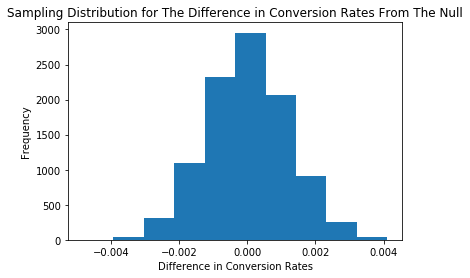

In [30]:
plt.hist(p_diffs)
plt.title('Sampling Distribution for The Difference in Conversion Rates From The Null')
plt.xlabel('Difference in Conversion Rates')
plt.ylabel('Frequency');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

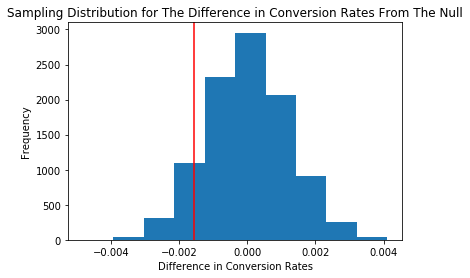

In [31]:
plt.hist(p_diffs)
plt.axvline(x=obs_diff, c='r')
plt.title('Sampling Distribution for The Difference in Conversion Rates From The Null')
plt.xlabel('Difference in Conversion Rates')
plt.ylabel('Frequency');

In [32]:
(obs_diff < p_diffs).mean()

0.9084

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**The calculated value is known as (p-value), which is the probability of observing your statistic (or one more extreme in favor of the alternative) if the null hypothesis is true. Since our (p-value) is greater than type I error rate of 5%, the difference between the new and old pages doesn't appear to be significant. We fail to reject the null hypothesis.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [33]:
import statsmodels.api as sm

# number of conversions for each page
convert_old = len(df2[(df2.group == 'control') & (df2.converted == 1)])
convert_new = len(df2[(df2.group == 'treatment') & (df2.converted == 1)])

convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [34]:
z, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
z, p_value

(1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The difference between the new and old pages doesn't appear to be significant. We fail to reject the null hypothesis. Which is consistent with the results in parts j. and k.**

<hr>

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic Regression.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [35]:
# create a column for the intercept
df2['intercept'] = 1

# create the necessary dummy variables
df2[['control', 'ab_page']] = pd.get_dummies(df['group'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


In [36]:
# drop unuseful column
df2.drop('control', axis=1, inplace=True)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [37]:
# logistic regression model
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [38]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 20 Aug 2020   Pseudo R-squ.:               8.077e-06
Time:                        20:11:11   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

- **The p_value 0.190 suggest that ab_page isn't statistically significant in predicting if a user would convert. (since it is greater than type I error rate of 5%).** 
- **It differs from the p_value in Part || because in regression p_values are always given for testing if the parameter for the intercept or the slop are equal to zero.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

- **Adding more features to the dataset and then using them in the model could help in better predicting whether a user would convert or not. Such as the time spent on the page, user's age ... etc.**
- **We have to be careful of what features we put together in a model to avoid multicollinearity (x-variables are related to one another).**


g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [39]:
countries_df = pd.read_csv('./countries.csv')
# join the dfs on user_id
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [40]:
# check the counrty values
df_new.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [41]:
# create the necessary dummy variables
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [42]:
# logistic regression model
logit_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'CA', 'UK']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Thu, 20 Aug 2020   Pseudo R-squ.:               1.521e-05
Time:                        20:11:13   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
CA            -0.0408      0.027     -1.518      0.129      -0.093       0.012
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

**the p_values (0.129, 0.456) suggest that the country isn't statistically significant in predicting if a user would convert. (since they are greater than type I error rate of 5%).**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [43]:
# create columns for the interaction between page and country 
df_new['CA_page'] = df_new['ab_page'] * df_new['CA']
df_new['UK_page'] = df_new['ab_page'] * df_new['UK']
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US,CA_page,UK_page
user_id,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,0,1


In [44]:
# logistic regression model
logit_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'CA_page', 'UK_page', \
                                                  'CA', 'UK', 'ab_page']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Thu, 20 Aug 2020   Pseudo R-squ.:               3.482e-05
Time:                        20:11:14   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
CA_page       -0.0469      0.054     -0.872      0.383      -0.152       0.059
UK_page        0.0314      0.027      1.181      0.238      -0.021       0.084
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
==============================================================================
"""

**The p_values suggest that an interaction between country and page received isn't statistically significant in predicting if a user would convert.<br> (since they are greater than type I error rate of 5%).**

<hr>

<a id='conclusions'></a>
### Conclusions

- The experiment duration was short. It would be advised that the company run the experiment for a longer period before making their final decision. 
- For the given data, the landing page and the country doesn't seem to have an effect on whether a user converts or not.
- Adding new features could help in better predicting whether a user would convert or not.

### References:
- Several questions on <a href='https://stackoverflow.com' target="_blank">Stack Overflow</a>.
- <a href='https://kite.com/python/docs/statsmodels.sandbox.tsa.movstat.sm.stats.proportions_ztest' target="_blank">proportions_ztest</a>.